In [ ]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
from joblib import  Memory

import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

In [ ]:
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)

In [ ]:
def debug(func):
    """Print the function signature and return value"""
    import functools

    @functools.wraps(func)
    def wrapper_debug(*args, **kwargs):
        args_repr = [repr(a) for a in args]
        kwargs_repr = [f"{k}={v!r}" for k, v in kwargs.items()]
        signature = ", ".join(args_repr + kwargs_repr)
        print(f"Calling {func.__name__}({signature})")
        values = func(*args, **kwargs)
        print(f"{func.__name__!r} returned {values!r}")
        return values

    return wrapper_debug

def theta_hat_func(n,m, MLE):
       #n,m are integer arrays
    if MLE==True:
        theta_hat = n-m
    else:
        # non-MLE
        # theta_hat = n-m
        # theta_hat = (theta_hat) * (theta_hat > 0)
        theta_hat = np.where(n>m, n-m, 0)
         
    return theta_hat


def L_prof_global(n,m, MLE):
    #n,m integer arrays
    # nu_hat = m, if theta_hat = theta_hat_MLE
    # nu_hat  =  (m+n)/2 if theta_hat = n-m
    # nu_hat = 0  if theta_hat != n-m
    theta_hat=theta_hat_func(n,m,MLE)
    # print('n-m ',  n-m)
    if MLE==True:
        # i.e. if theta_hat = n-m
        # assert theta_hat==n-m
        nu_hat = m
    else:
        nu_hat = np.where(theta_hat ==0, (m+n)/2, m)
        # if theta_hat==0:
        #     nu_hat =(m+n)/2
        # else:
        #     _hat = m
        # # if theta_hat== n-m:
        # #     nu_hat = (m+n)/2
        # # else:
        # #     nu_hat = 0
        # # nu_hat = np.where(theta_hat==n-m,
        # #                   (m+n)/2, 
        # #                   0)
    p1=st.poisson.pmf(n, theta_hat+nu_hat)
    p2 = st.poisson.pmf(m, nu_hat)
    return p1*p2

def L_theta_nu(n,m,theta,nu):
    p1 = st.poisson.pmf(n, theta+nu)
    p2 = st.poisson.pmf(m, nu)
    return p1*p2
def lambda_test_2d(n,m, theta, nu, MLE):
    Ln= L_theta_nu(n,m,theta,nu)
    
    Ld= L_prof_global(n,m, MLE)
    eps=1e-20
    Ld=Ld+eps
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

In [ ]:
class SiLURegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.SiLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                layers.append(nn.SiLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

In [ ]:
@debug
def load_untrained_model(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"],
        # activation=PARAMS["activation"]
    )
    # model.apply(initialize_weights)
    print('INITIATED UNTRAINED MODEL:',
          # model
         )
    # print(model)
    return model
    

In [ ]:
PARAMS_lambdaD_nonMLE_SILU = {
"n_layers": int(12),
"hidden_size": int(12),
"dropout": float(0.13),
"NFEATURES":int(3),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.0006),
'momentum':float(0.9),
'batch_size':int(256*2),
'n_iterations': int(1e5),
'traces_step':int(100),
'L2':float(0.1),
'MLE':False,
'with_lambda_D':True,
'pth_string':'FEB_20_model_lambda_D_nonMLE_SILU.pth'
}

In [ ]:
untrained_SiLU_model_nonMLE = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

Calling load_untrained_model({'n_layers': 12, 'hidden_size': 12, 'dropout': 0.13, 'NFEATURES': 3, 'activation': 'SiLU', 'optimizer_name': 'NAdam', 'starting_learning_rate': 0.0006, 'momentum': 0.9, 'batch_size': 512, 'n_iterations': 100000, 'traces_step': 100, 'L2': 0.1, 'MLE': False, 'with_lambda_D': True, 'pth_string': 'FEB_20_model_lambda_D_nonMLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_model' returned SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (1

In [ ]:
def load_model(model, PARAMS, pth_string):
    models_path = os.path.join(os.getcwd(), '../models')
    PATH=os.path.join(models_path, pth_string)
    model = SiLURegressionModel(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"]
    )
    checkpoint = torch.load(PATH)
    print('INITIATED MODEL:',  model)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'loading model with th string : {pth_string}\n')    
    print(model)
    
    return model

In [ ]:
# untrained_SiLU_model = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

trained_SiLU_model_nonMLE = load_model(model = untrained_SiLU_model_nonMLE, 
                                PARAMS=PARAMS_lambdaD_nonMLE_SILU,
                   pth_string=PARAMS_lambdaD_nonMLE_SILU["pth_string"])

INITIATED MODEL: SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): Dropout(p=0.13, inplace=False)
    (14): SiLU()
    (15): Linear(in_features=12, out_features=12, bias=True)
    (16): Dropout(p=0.13, inplace=False)
    (17): SiLU()
    (18): Linear(in_features=12, out_features=12, bias=True)
    (19): Dropout(p=0.13, inplace=False)
    (20): SiLU()
    (21): Linear(in_features=12, out_features=12, bias=True)
    (22): Dropout(p=0.13, inplace=False)
    (23): SiLU(

In [ ]:
def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


number_of_parameters(trained_SiLU_model_nonMLE)

1777

In [ ]:
PARAMS_lambdaD_MLE_SILU = {
"n_layers": int(12),
"hidden_size": int(12),
"dropout": float(0.13),
"NFEATURES":int(3),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.0006),
'momentum':float(0.9),
'batch_size':int(256*2),
'n_iterations': int(6e4),
'traces_step':int(100),
'L2':float(0.1),
'MLE':True,
'with_lambda_D':True,
'pth_string':'FEB_20_model_lambda_D_MLE_SILU.pth'
}

In [ ]:
untrained_SiLU_model_MLE = load_untrained_model(PARAMS_lambdaD_MLE_SILU)

Calling load_untrained_model({'n_layers': 12, 'hidden_size': 12, 'dropout': 0.13, 'NFEATURES': 3, 'activation': 'SiLU', 'optimizer_name': 'NAdam', 'starting_learning_rate': 0.0006, 'momentum': 0.9, 'batch_size': 512, 'n_iterations': 60000, 'traces_step': 100, 'L2': 0.1, 'MLE': True, 'with_lambda_D': True, 'pth_string': 'FEB_20_model_lambda_D_MLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_model' returned SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): D

In [ ]:
# untrained_SiLU_model = load_untrained_model(PARAMS_lambdaD_nonMLE_SILU)

trained_SiLU_model_MLE = load_model(model = untrained_SiLU_model_MLE, 
                                PARAMS=PARAMS_lambdaD_MLE_SILU,
                   pth_string=PARAMS_lambdaD_MLE_SILU["pth_string"])

INITIATED MODEL: SiLURegressionModel(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Dropout(p=0.13, inplace=False)
    (2): SiLU()
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): Dropout(p=0.13, inplace=False)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=12, bias=True)
    (7): Dropout(p=0.13, inplace=False)
    (8): SiLU()
    (9): Linear(in_features=12, out_features=12, bias=True)
    (10): Dropout(p=0.13, inplace=False)
    (11): SiLU()
    (12): Linear(in_features=12, out_features=12, bias=True)
    (13): Dropout(p=0.13, inplace=False)
    (14): SiLU()
    (15): Linear(in_features=12, out_features=12, bias=True)
    (16): Dropout(p=0.13, inplace=False)
    (17): SiLU()
    (18): Linear(in_features=12, out_features=12, bias=True)
    (19): Dropout(p=0.13, inplace=False)
    (20): SiLU()
    (21): Linear(in_features=12, out_features=12, bias=True)
    (22): Dropout(p=0.13, inplace=False)
    (23): SiLU(

# Summary: We have loaded `trained_SiLU_model_nonMLE` and `trained_SiLU_model_MLE`

In [42]:
class TrainedModel:
    def __init__(self, model):
        self.model = model

    def __cdf(self, x):
        # convert to a tensor and compute
 
        X = torch.Tensor(x)#.transpose(1, 0)
            
        X.requires_grad_(True)
        
        self.model.eval() 
        
        return self.model(X), X 
        
    def cdf(self, x): 
        F, _ = self.__cdf(x)
        
        Y = F.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y

        
        Y = F.view(-1).detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y
    
    def numerical_deriv(self,x):
        h=1E-3
        F_h = self.cdf(x+h)
        F = self.cdf(x)
        deriv = (F_h-F)/h
        return deriv
        

    def pdf(self, x):
        F, X = self.__cdf(x)

        dFdX = torch.autograd.grad(outputs=F, inputs=X, 
                               grad_outputs=torch.ones_like(F),
                               #allow_unused=True, 
                               #retain_graph=True, 
                               create_graph=True)[0]
    
        # Y = dFdX.view(-1).detach().numpy()
        Y = dFdX.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y.T[-1]  


In [43]:
def generate_X(theta, nu, N_points, MLE):
    N = st.poisson.rvs(theta+nu, size=N_points)
    M = st.poisson.rvs(nu, size=N_points)
    lambda_D = lambda_test_2d(N, M, theta, nu, MLE).flatten()
    X = np.empty((N_points, 3))
    X[:,0] = np.ones_like(theta)*theta
    X[:,1] = np.ones_like(nu)*nu
    X[:,2]  = lambda_D
    return X

In [255]:
Bprime=21000
thetamin, thetamax  =0,20
numin, numax  =0,20
theta = st.uniform.rvs(thetamin, thetamax, size=Bprime)
nu = st.uniform.rvs(numin, numax, size=Bprime)
data = pd.DataFrame({'theta':theta, 'nu':nu})

data.head()

,theta,nu
0,5.262529,10.413715
1,2.054565,13.174039
2,16.096403,14.990477
3,18.272949,16.544302
4,7.629151,7.977697


In [256]:

tmodel = TrainedModel(trained_SiLU_model_nonMLE)


In [257]:
def precision(arr):
    return [float(int(1000*x))/1000 for x in arr]

In [258]:
for rowind, row in data.iterrows():
    N=100
    X = generate_X(theta=row['theta'], nu=row['nu'], N_points=N, MLE=False)
    lambda_ = X[:,2].flatten()
    # lambda_ = [float(int(1000*x))/1000 for x in lambda_]
    lambda_ = precision(lambda_)
    # data.loc[rowind, 'lambda'] = [str(x) for x in lambda_]
    data.loc[rowind, 'lambda'] =str(lambda_)
    a = tmodel.cdf(X)

    p  = np.linspace(0,1,N)
    
    q = np.quantile(a,p)

    q = precision(q)
    data.loc[rowind, 'q'] = str(q)
    delta_C = p-q
    delta_C = precision(delta_C)
    data.loc[rowind, 'delta_C'] = str(delta_C)

In [259]:
data

,theta,nu,lambda,q,delta_C
0,5.262529,10.413715,"[0.624, 2.434, 4.856, 3.149, 0.361, 3.149, 1.0...","[0.051, 0.054, 0.054, 0.055, 0.055, 0.08, 0.08...","[-0.051, -0.043, -0.033, -0.024, -0.014, -0.02..."
1,2.054565,13.174039,"[0.723, 4.176, 0.005, 1.739, 1.528, 1.493, 0.0...","[0.05, 0.056, 0.056, 0.058, 0.063, 0.063, 0.06...","[-0.05, -0.045, -0.035, -0.027, -0.022, -0.012..."
2,16.096403,14.990477,"[2.961, 0.401, 0.629, 2.572, 8.052, 1.626, 0.1...","[0.038, 0.042, 0.044, 0.049, 0.049, 0.053, 0.0...","[-0.038, -0.031, -0.023, -0.018, -0.008, -0.00..."
3,18.272949,16.544302,"[2.592, 2.964, 0.367, 1.339, 0.413, 2.659, 3.6...","[0.037, 0.038, 0.038, 0.04, 0.04, 0.044, 0.053...","[-0.037, -0.027, -0.017, -0.009, 0.0, 0.006, 0..."
4,7.629151,7.977697,"[1.38, 1.032, 2.054, 0.171, 3.286, 2.157, 0.81...","[0.05, 0.05, 0.05, 0.052, 0.069, 0.069, 0.069,...","[-0.05, -0.039, -0.029, -0.021, -0.028, -0.018..."
...,...,...,...,...,...
20995,4.468149,0.140677,"[4.443, 2.236, 0.922, 2.845, 2.159, 2.159, 0.6...","[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...","[-0.125, -0.114, -0.104, -0.094, -0.084, -0.07..."
20996,7.172839,18.255783,"[8.481, 1.15, 1.255, 3.976, 3.084, 0.641, 0.93...","[0.043, 0.048, 0.048, 0.048, 0.048, 0.057, 0.0...","[-0.043, -0.037, -0.027, -0.017, -0.007, -0.00..."
20997,15.959315,14.070910,"[6.359, 5.255, 0.954, 0.607, 3.889, 3.107, 1.1...","[0.053, 0.053, 0.058, 0.059, 0.068, 0.07, 0.07...","[-0.053, -0.042, -0.037, -0.028, -0.027, -0.01..."
20998,19.113667,19.978409,"[2.669, 1.611, 1.188, 2.089, 0.892, 13.543, 0....","[0.031, 0.036, 0.039, 0.043, 0.043, 0.044, 0.0...","[-0.031, -0.025, -0.018, -0.012, -0.002, 0.006..."


In [260]:
theta_l = []
nu_l= []
q_l = []
delta_C_l = []
lambda_l = []

for row_ind, row in data.iterrows():
#     lambda_ = eval(row['lambda'])
#     lambda_l.append(lambda_)
    
    q=eval(row['q'])
    
    theta_r = np.full_like(q, row['theta'])
    theta_l.append(theta_r)
    
    nu_r = np.full_like(q, row['nu'])
    nu_l.append(nu_r)
    
    q_l.append(q)
    
    delta_C = eval(row['delta_C'])
    delta_C_l.append(delta_C)
    

    
theta_l=np.array(theta_l).flatten()
nu_l=np.array(nu_l).flatten()
q_l=np.array(q_l).flatten()
delta_C_l=np.array(delta_C_l).flatten()
# lambda_l = np.array(lambda_l).flatten()

# y = delta_C_l - min(delta_C_l)
# y = y/np.std(y)


In [261]:
data_flat=pd.DataFrame({'theta': theta_l,
                       'nu': nu_l,
                       'q': q_l,
                        # 'lambda':lambda_l,
                       'delta_C': delta_C_l})
data_flat[:10]

,theta,nu,q,delta_C
0,5.262529,10.413715,0.051,-0.051
1,5.262529,10.413715,0.054,-0.043
2,5.262529,10.413715,0.054,-0.033
3,5.262529,10.413715,0.055,-0.024
4,5.262529,10.413715,0.055,-0.014
5,5.262529,10.413715,0.080,-0.029
6,5.262529,10.413715,0.082,-0.021
7,5.262529,10.413715,0.115,-0.044
8,5.262529,10.413715,0.115,-0.034
9,5.262529,10.413715,0.122,-0.031


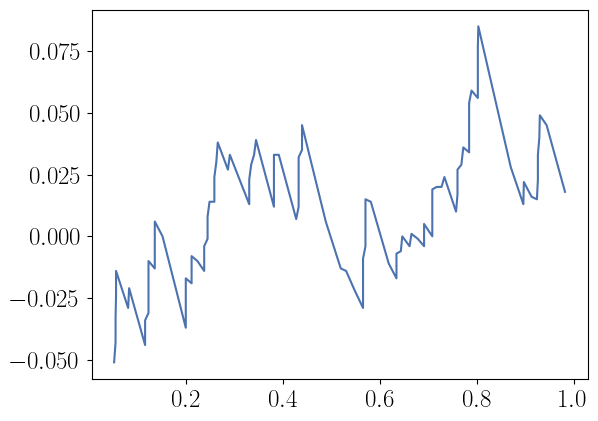

In [262]:
plt.plot(data_flat['q'][:100], data_flat['delta_C'][:100]);plt.show()

In [263]:
data_flat.to_csv('On_Off_Flat_q_deltaC.csv')

-------------
# Machine Learning

In [594]:
class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)
    
class Delta_C_Model(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layer = nn.Linear(nfeatures, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight, gain=60)
                torch.nn.init.xavier_normal_(layer.weight, gain=60)
                layers.append(layer)
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                #ReLU activation 
                # layers.append(nn.SiLU())
                layers.append(SinActivation())
            else:
                #if this is not the first layer (we dont have layers)
                layer = nn.Linear(hidden_size, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight, gain=60)
                torch.nn.init.xavier_normal_(layer.weight, 
                                             # gain=60
                                            )
                layers.append(layer)
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                # layers.append(nn.SiLU())
                layers.append(nn.Tanh())
                #output layer:
        output_layer = nn.Linear(hidden_size, ntargets)
        torch.nn.init.xavier_uniform_(output_layer.weight)
        layers.append(output_layer) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        # layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

In [595]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

    
class SiLURegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.SiLU())
                
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                layers.append(nn.SiLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        # layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)
    

In [596]:
def getwholedata_delta_C():
    """ Get train test split arrays"""
    
    data = data_flat
        
    train_data, test_data = train_test_split(data_flat, test_size=0.1)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='delta_C'
    # target='y'
    # source = ['theta','nu','theta_hat','N','M']

    source = ['theta', 'nu', 'q']

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    # if valid:
        #if you want to also make a validation data set
    train_data, valid_data = train_test_split(train_data, test_size=0.015)
    valid_data = valid_data.reset_index(drop=True)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    return train_t, train_x, test_t,  test_x, valid_t, valid_x

In [559]:
train_t, train_x, test_t,  test_x, valid_t, valid_x = getwholedata_delta_C()

train_t shape =  (1890000,) 

train_x shape =  (1890000, 3) 



In [560]:
valid_x

array([[ 9.51509182,  7.59816967,  0.31      ],
       [ 9.91260271,  6.68026759,  0.61      ],
       [ 0.61624997,  2.55793089,  0.561     ],
       ...,
       [ 1.06146512,  1.42380955,  0.099     ],
       [ 1.79459214,  7.91416594,  0.075     ],
       [ 7.25637484, 19.07718359,  0.308     ]])

In [561]:
N_Features = train_x.shape[1]

In [597]:
def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

In [598]:
def save_model(model, PARAMS, pth_string):
    """pth string is the name of the pth file which is a 
    dictionary of dictionaries"""
    models_path = os.path.join(os.getcwd(), '../models')
    PATH=os.path.join(models_path, pth_string)
    print(f'saving model with th string : {pth_string}\n')
    torch.save({'PARAMS': PARAMS,
                'model_state_dict': model.state_dict()},
                PATH)
    print(model)

In [599]:
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape

    inv = torch.where(t !=0, 1/torch.abs(t), 1)
    return  torch.mean( inv * (f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)
def train(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window, MLE, with_lambda_D):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    

    
    if MLE==True:
        train_t, train_x, test_t,  test_x, _, _ = getwholedata_delta_C()
    else:
        train_t, train_x, test_t,  test_x, _, _ = getwholedata_delta_C()
        
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            #using Ali's loader
            # acc_t = validate(model, avloss, batch_x, batch_t) 
            # acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

In [600]:
PARAMS_Delta_C_nonMLE = {
"n_layers": int(6),
"hidden_size": int(4),
"dropout": float(0.13),
"NFEATURES":int(N_Features),
"activation": "SiLU",
'optimizer_name':'Adam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.0006),
'momentum':float(0.9),
'batch_size':int(56),
'n_iterations': int(1e5),
'traces_step':int(100),
'L2':float(0.1),
'MLE':False,
'with_lambda_D':True,
'pth_string':'Delta_C_nonMLE_SILU.pth'
}

In [601]:
@debug
def load_untrained_model_Delta_C(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = Delta_C_Model(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"],
        # activation=PARAMS["activation"]
    )
    # model.apply(initialize_weights)
    print('INITIATED UNTRAINED MODEL:',
          # model
         )
    # print(model)
    return model
    

In [602]:
untrained_Delta_C_nonMLE = load_untrained_model_Delta_C(PARAMS_Delta_C_nonMLE)

BATCHSIZE=PARAMS_Delta_C_nonMLE["batch_size"]
traces_SiLU = ([], [], [], [])
traces_step = 2000
optimizer_name=PARAMS_Delta_C_nonMLE["optimizer_name"]

optimizer_SiLU = getattr(torch.optim, str(optimizer_name))(untrained_Delta_C_nonMLE.parameters(), 
                                                           lr=PARAMS_Delta_C_nonMLE["starting_learning_rate"])

traces_SiLU = train(model=untrained_Delta_C_nonMLE, 
              optimizer=optimizer_SiLU, 
              avloss=average_quadratic_loss,
              batch_size=BATCHSIZE, 
              n_iterations=PARAMS_Delta_C_nonMLE["n_iterations"], 
              traces=traces_SiLU, 
              step=traces_step, 
              window=200,
                MLE=False,
                with_lambda_D=True)

Calling load_untrained_model_Delta_C({'n_layers': 6, 'hidden_size': 4, 'dropout': 0.13, 'NFEATURES': 3, 'activation': 'SiLU', 'optimizer_name': 'Adam', 'starting_learning_rate': 0.0006, 'momentum': 0.9, 'batch_size': 56, 'n_iterations': 100000, 'traces_step': 100, 'L2': 0.1, 'MLE': False, 'with_lambda_D': True, 'pth_string': 'Delta_C_nonMLE_SILU.pth'})
INITIATED UNTRAINED MODEL:
'load_untrained_model_Delta_C' returned Delta_C_Model(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): SinActivation()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): Tanh()
    (4): Linear(in_features=4, out_features=4, bias=True)
    (5): Tanh()
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): Tanh()
    (8): Linear(in_features=4, out_features=4, bias=True)
    (9): Tanh()
    (10): Linear(in_features=4, out_features=4, bias=True)
    (11): Tanh()
    (12): Linear(in_features=4, out_features=1, bias=True)
  )
)
train_t shape =  (18

KeyboardInterrupt: 

In [603]:
def generate_theta_nu_q(theta, nu, N_points):
    """non MLE evaluation data for the correction function at a single theta, nu point"""
    data = pd.DataFrame({'theta':[theta], 'nu':[nu]})
    tmodel = TrainedModel(trained_SiLU_model_nonMLE)

    
    for rowind, row in data.iterrows():
        X = generate_X(theta=row['theta'], nu=row['nu'], N_points=N_points, MLE=False)
        # lambda_ = X[:,2].flatten()
        # lambda_ = precision(lambda_)
        
        # data.loc[rowind, 'lambda'] =str(lambda_)
        
        a = tmodel.cdf(X)

        p  = np.linspace(0,1,N_points)

        q = np.quantile(a, p)

        q = precision(q)
        data.loc[rowind, 'q'] = str(q)
        delta_C = p-q
        delta_C = precision(delta_C)
        data.loc[rowind, 'delta_C'] = str(delta_C)
    

    theta_l = []
    nu_l= []
    q_l = []
    delta_C_l = []
    # lambda_l = []

    for row_ind, row in data.iterrows():
        # lambda_ = eval(row['lambda'])
        # lambda_l.append(lambda_)
        
        q=eval(row['q'])

        theta_r = np.full_like(q, row['theta'])
        theta_l.append(theta_r)

        nu_r = np.full_like(q, row['nu'])
        nu_l.append(nu_r)

        q_l.append(q)

        delta_C = eval(row['delta_C'])
        delta_C_l.append(delta_C)

    theta_l=np.array(theta_l).flatten()
    nu_l=np.array(nu_l).flatten()
    q_l=np.array(q_l).flatten()
    delta_C_l=np.array(delta_C_l).flatten()
    # lambda_l=np.array(lambda_l).flatten()
    
    # y = delta_C_l - min(delta_C_l)
    # y = y/np.std(y)

    data_flat=pd.DataFrame({'theta': theta_l,
                       'nu': nu_l,
                       'q': q_l,
                        # 'lambda':lambda_l,
                       'delta_C': delta_C_l,
                           # 'y':y
                           })
    
    eval_array = data_flat[['theta', 'nu', 'q']].to_numpy()
    return data_flat, eval_array

In [604]:
data_flat_eval, eval_array =generate_theta_nu_q(theta=20, nu=5, N_points=10000)

In [605]:
data_flat_eval

,theta,nu,q,delta_C
0,20.0,5.0,0.039,-0.039
1,20.0,5.0,0.039,-0.038
2,20.0,5.0,0.039,-0.038
3,20.0,5.0,0.039,-0.038
4,20.0,5.0,0.039,-0.038
...,...,...,...,...
9995,20.0,5.0,0.999,0.000
9996,20.0,5.0,0.999,0.000
9997,20.0,5.0,0.999,0.000
9998,20.0,5.0,0.999,0.000


In [606]:
eval_array[:5]

array([[20.   ,  5.   ,  0.039],
       [20.   ,  5.   ,  0.039],
       [20.   ,  5.   ,  0.039],
       [20.   ,  5.   ,  0.039],
       [20.   ,  5.   ,  0.039]])

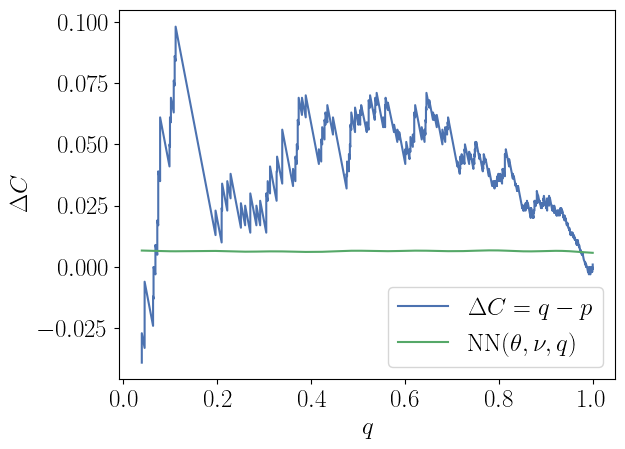

In [607]:
plt.plot(data_flat_eval['q'],data_flat_eval['delta_C'], label='$\Delta C = q-p$')

delta_C_hat = untrained_Delta_C_nonMLE(torch.Tensor(eval_array)).detach().numpy()
q=eval_array[:,-1]
q.sort()
delta_C_hat.sort()
plt.plot(q,delta_C_hat, label=r'NN($\theta, \nu , q $)')

plt.xlabel('$q$')
plt.ylabel('$\Delta C$')
plt.legend()
plt.show()

In [614]:
def plot_q_deltaC_points(nrows, ncols):
    fig, ax = plt.subplots(5,5, figsize=(20,20))
    ax = ax.ravel()
    theta_nu_l = [(theta, nu) for theta in np.linspace(5,5.2, nrows) for nu in np.linspace(5,5.2, ncols)]
    for ind, (theta, nu) in enumerate(theta_nu_l):
        data_flat_eval, eval_array =generate_theta_nu_q(theta=theta, nu=nu, N_points=101)
        ax[ind].plot(data_flat_eval['q'],data_flat_eval['delta_C'], label='$\Delta C = q-p$')
        xmin, xmax = 0,1 
        ymin, ymax = data_flat_eval['delta_C'].min(), data_flat_eval['delta_C'].max()
        xwid = (xmax-xmin)/12
        ywid = (ymax-ymin)/12
        xpos = xmin + 3*xwid
        ypos = ymin + ywid
        
        ax[ind].plot([0,1],[0,0], linestyle='dashed', color='r')
        ax[ind].text(xpos, ypos, r'$ \theta = %.2f, \nu = %.2f$' % (theta, nu))
        ax[ind].set_ylim(-0.1,0.125)
        ax[ind].set_xlabel(r'$q$')
        ax[ind].set_ylabel(r'$\Delta C=p-q$')
    plt.tight_layout()
    plt.show()

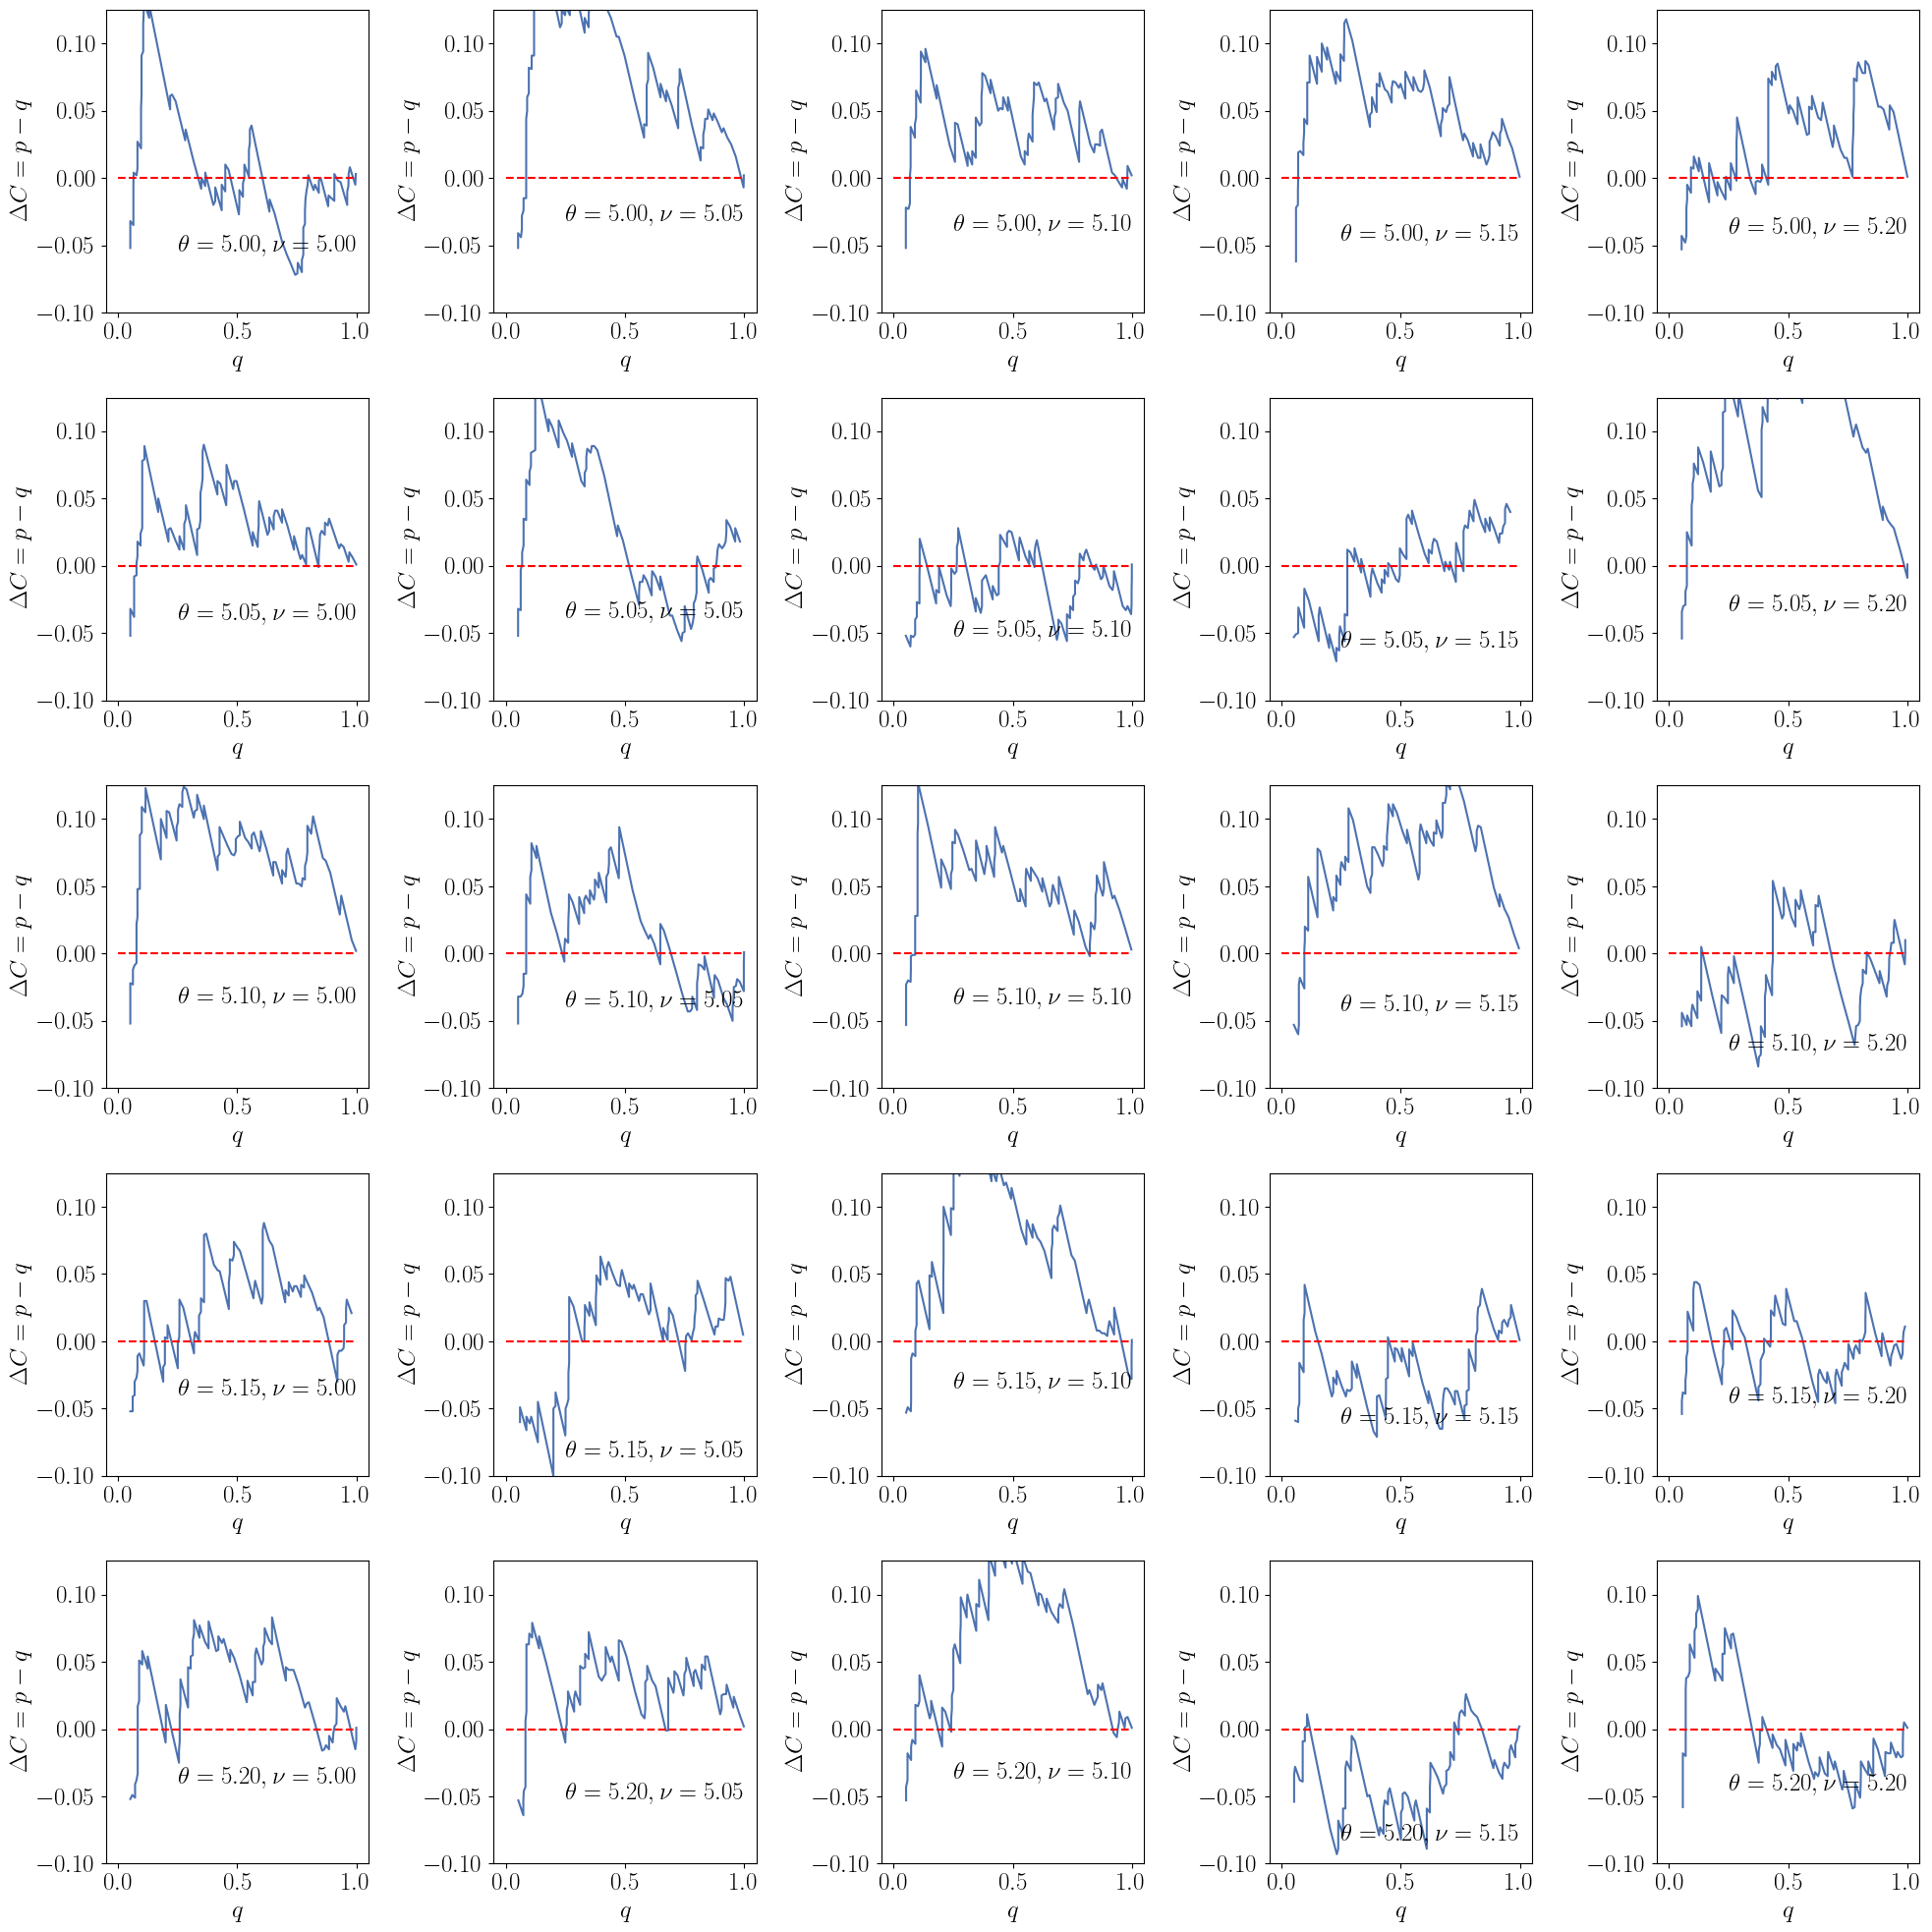

In [615]:
plot_q_deltaC_points(nrows=5, ncols=5)

# Mapping the residuals as a function of $\lambda$

In [661]:
def cdf(lst, x):

    count = sum(1 for num in lst if num <= x)
    return count / len(lst)

In [712]:
def generate_theta_nu_CDF(theta, nu, N_points):
    """non MLE evaluation data for the correction function at a single theta, nu point"""
    data = pd.DataFrame({'theta':[theta], 'nu':[nu]})
    tmodel = TrainedModel(trained_SiLU_model_nonMLE)

    
    for rowind, row in data.iterrows():
        X = generate_X(theta=row['theta'], nu=row['nu'], N_points=N_points, MLE=False)
        lambda_ = X[:,2].flatten()
        lambda_ = precision(lambda_)
        
        data.loc[rowind, 'lambda'] =str(lambda_)
        
        true_CDF_l = []
        for lambda_val in lambda_:
            true_CDF_l.append(cdf(lambda_, lambda_val))
            
        a = tmodel.cdf(X)

        p  = np.linspace(0,1,N_points)

        q = np.quantile(a, p)

        q = precision(q)
        data.loc[rowind, 'q'] = str(q)
        
        a = precision(a)
        data.loc[rowind, 'pred_CDF'] =str(a)
        
        delta_C = p-q
        delta_C = precision(delta_C)
        data.loc[rowind, 'delta_C'] = str(delta_C)
    

    theta_l = []
    nu_l= []
    q_l = []
    delta_C_l = []
    lambda_l = []
    pred_CDF_l = []
    

    for row_ind, row in data.iterrows():
        lambda_ = eval(row['lambda'])
        lambda_l.append(lambda_)
        
        
        q=eval(row['q'])
        q_l.append(q)

        pred_CDF = eval(row['pred_CDF'])
        pred_CDF_l.append(pred_CDF)
            
        theta_r = np.full_like(q, row['theta'])
        theta_l.append(theta_r)

        nu_r = np.full_like(q, row['nu'])
        nu_l.append(nu_r)


        delta_C = eval(row['delta_C'])
        delta_C_l.append(delta_C)

    theta_l=np.array(theta_l).flatten()
    nu_l=np.array(nu_l).flatten()
    q_l=np.array(q_l).flatten()
    delta_C_l=np.array(delta_C_l).flatten()
    lambda_l=np.array(lambda_l).flatten()
    pred_CDF_l=np.array(pred_CDF_l).flatten()
    true_CDF_l=np.array(true_CDF_l).flatten()
    delta_r = pred_CDF_l-true_CDF_l
    
    
    # y = delta_C_l - min(delta_C_l)
    # y = y/np.std(y)

    data_flat=pd.DataFrame({'theta': theta_l,
                       'nu': nu_l,
                       'q': q_l,
                        'lambda':lambda_l,
                       'delta_C': delta_C_l,
                        'pred_CDF': pred_CDF_l,
                            'true_CDF':true_CDF_l,
                            'delta_r':delta_r,
                           # 'y':y
                           })
    
    eval_array = data_flat[['theta', 'nu', 'q']].to_numpy()
    return data_flat, eval_array

In [713]:
df, _ = generate_theta_nu_CDF(theta=19, nu=5, N_points=100)
df

,theta,nu,q,lambda,delta_C,pred_CDF,true_CDF,delta_r
0,19.0,5.0,0.040,0.041,-0.040,0.046,0.02,0.026
1,19.0,5.0,0.046,5.598,-0.035,0.912,0.97,-0.058
2,19.0,5.0,0.047,0.230,-0.026,0.075,0.14,-0.065
3,19.0,5.0,0.047,1.310,-0.016,0.430,0.48,-0.050
4,19.0,5.0,0.047,1.343,-0.006,0.438,0.49,-0.052
...,...,...,...,...,...,...,...,...
95,19.0,5.0,0.901,0.360,0.058,0.105,0.20,-0.095
96,19.0,5.0,0.912,3.212,0.057,0.762,0.85,-0.088
97,19.0,5.0,0.919,2.463,0.060,0.637,0.71,-0.073
98,19.0,5.0,0.925,0.042,0.064,0.047,0.05,-0.003


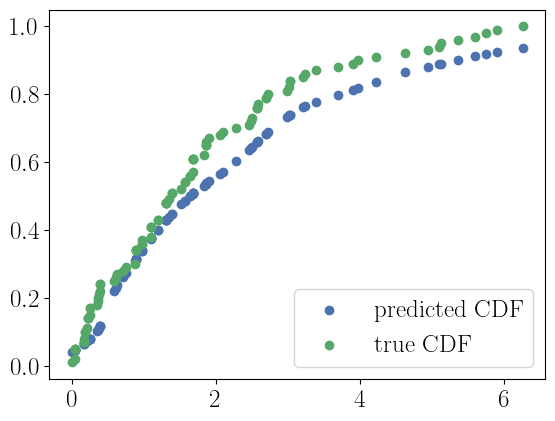

In [714]:
plt.scatter(df['lambda'], df['pred_CDF'], label='predicted CDF')

plt.scatter(df['lambda'], df['true_CDF'],label='true CDF')
plt.legend()
plt.show()

In [723]:
def plot_q_deltar_points(nrows, ncols, scatter = False):
    fig, ax = plt.subplots(5,5, figsize=(20,20))
    ax = ax.ravel()
    theta_nu_l = [(theta, nu) for theta in np.linspace(5,5.2, nrows) for nu in np.linspace(5,5.2, ncols)]
    for ind, (theta, nu) in enumerate(theta_nu_l):
        data_flat_eval, eval_array =generate_theta_nu_CDF(theta=theta, nu=nu, N_points=101)
        # delta_r = data_flat_eval['pred_CDF'] - data_flat_eval['true_CDF']
        delta_r=data_flat_eval['delta_r']
        if scatter:
            ax[ind].scatter(data_flat_eval['lambda'],delta_r, label=r'$\Delta r = F_{pred}-F_{true}$')
        else:
            ax[ind].plot(data_flat_eval['lambda'],delta_r, label=r'$\Delta r = F_{pred}-F_{true}$')
        xmin, xmax = 0,1 
        ymin, ymax = -0.1, 0.1
        xwid = (xmax-xmin)/12
        ywid = (ymax-ymin)/12
        xpos = xmin + 4*xwid
        ypos = ymin #+ ywid
        
        
        ax[ind].text(xpos, ypos, r'$ \theta = %.2f, \nu = %.2f$' % (theta, nu))
        ax[ind].set_ylim(-0.2,0.125)
        ax[ind].set_xlabel(r'$\lambda$')
        ax[ind].set_ylabel(r'$\Delta r = F_{pred}-F_{true}$')
        ax[ind].plot([0,1],[0,0], linestyle='dashed', color='r')
    plt.tight_layout()
    plt.show()

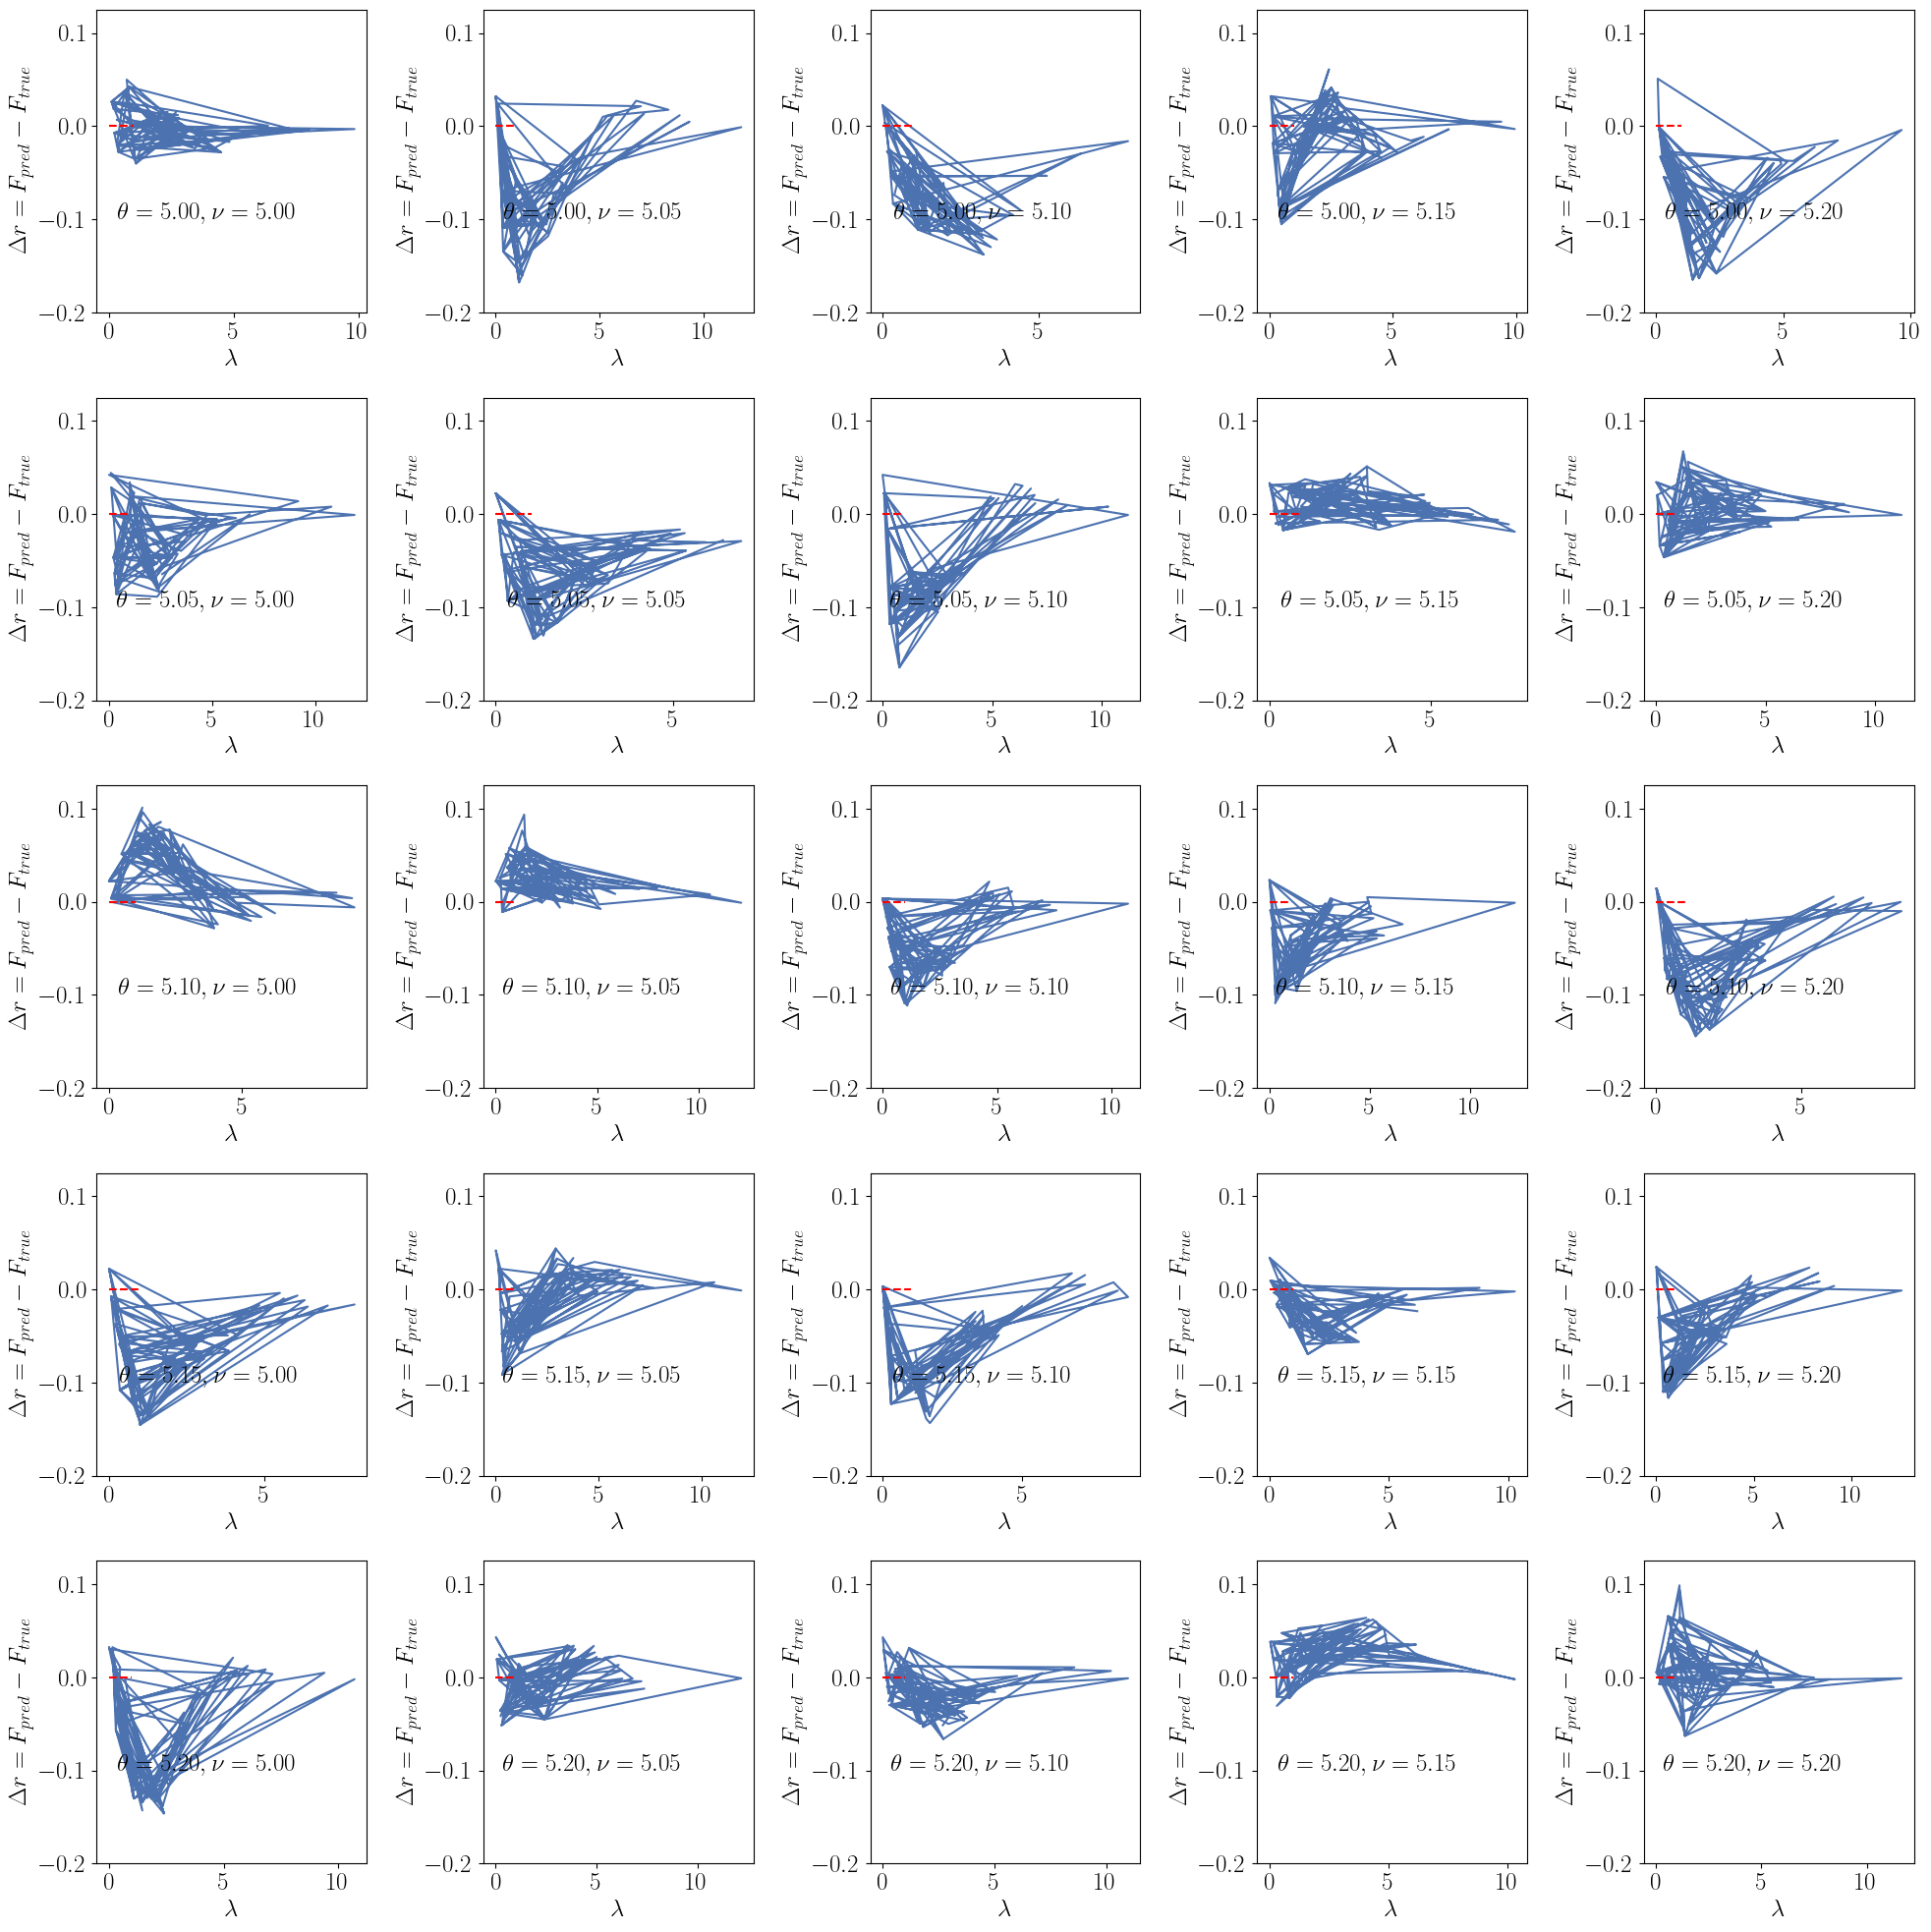

In [724]:
plot_q_deltar_points(nrows=5, ncols=5)

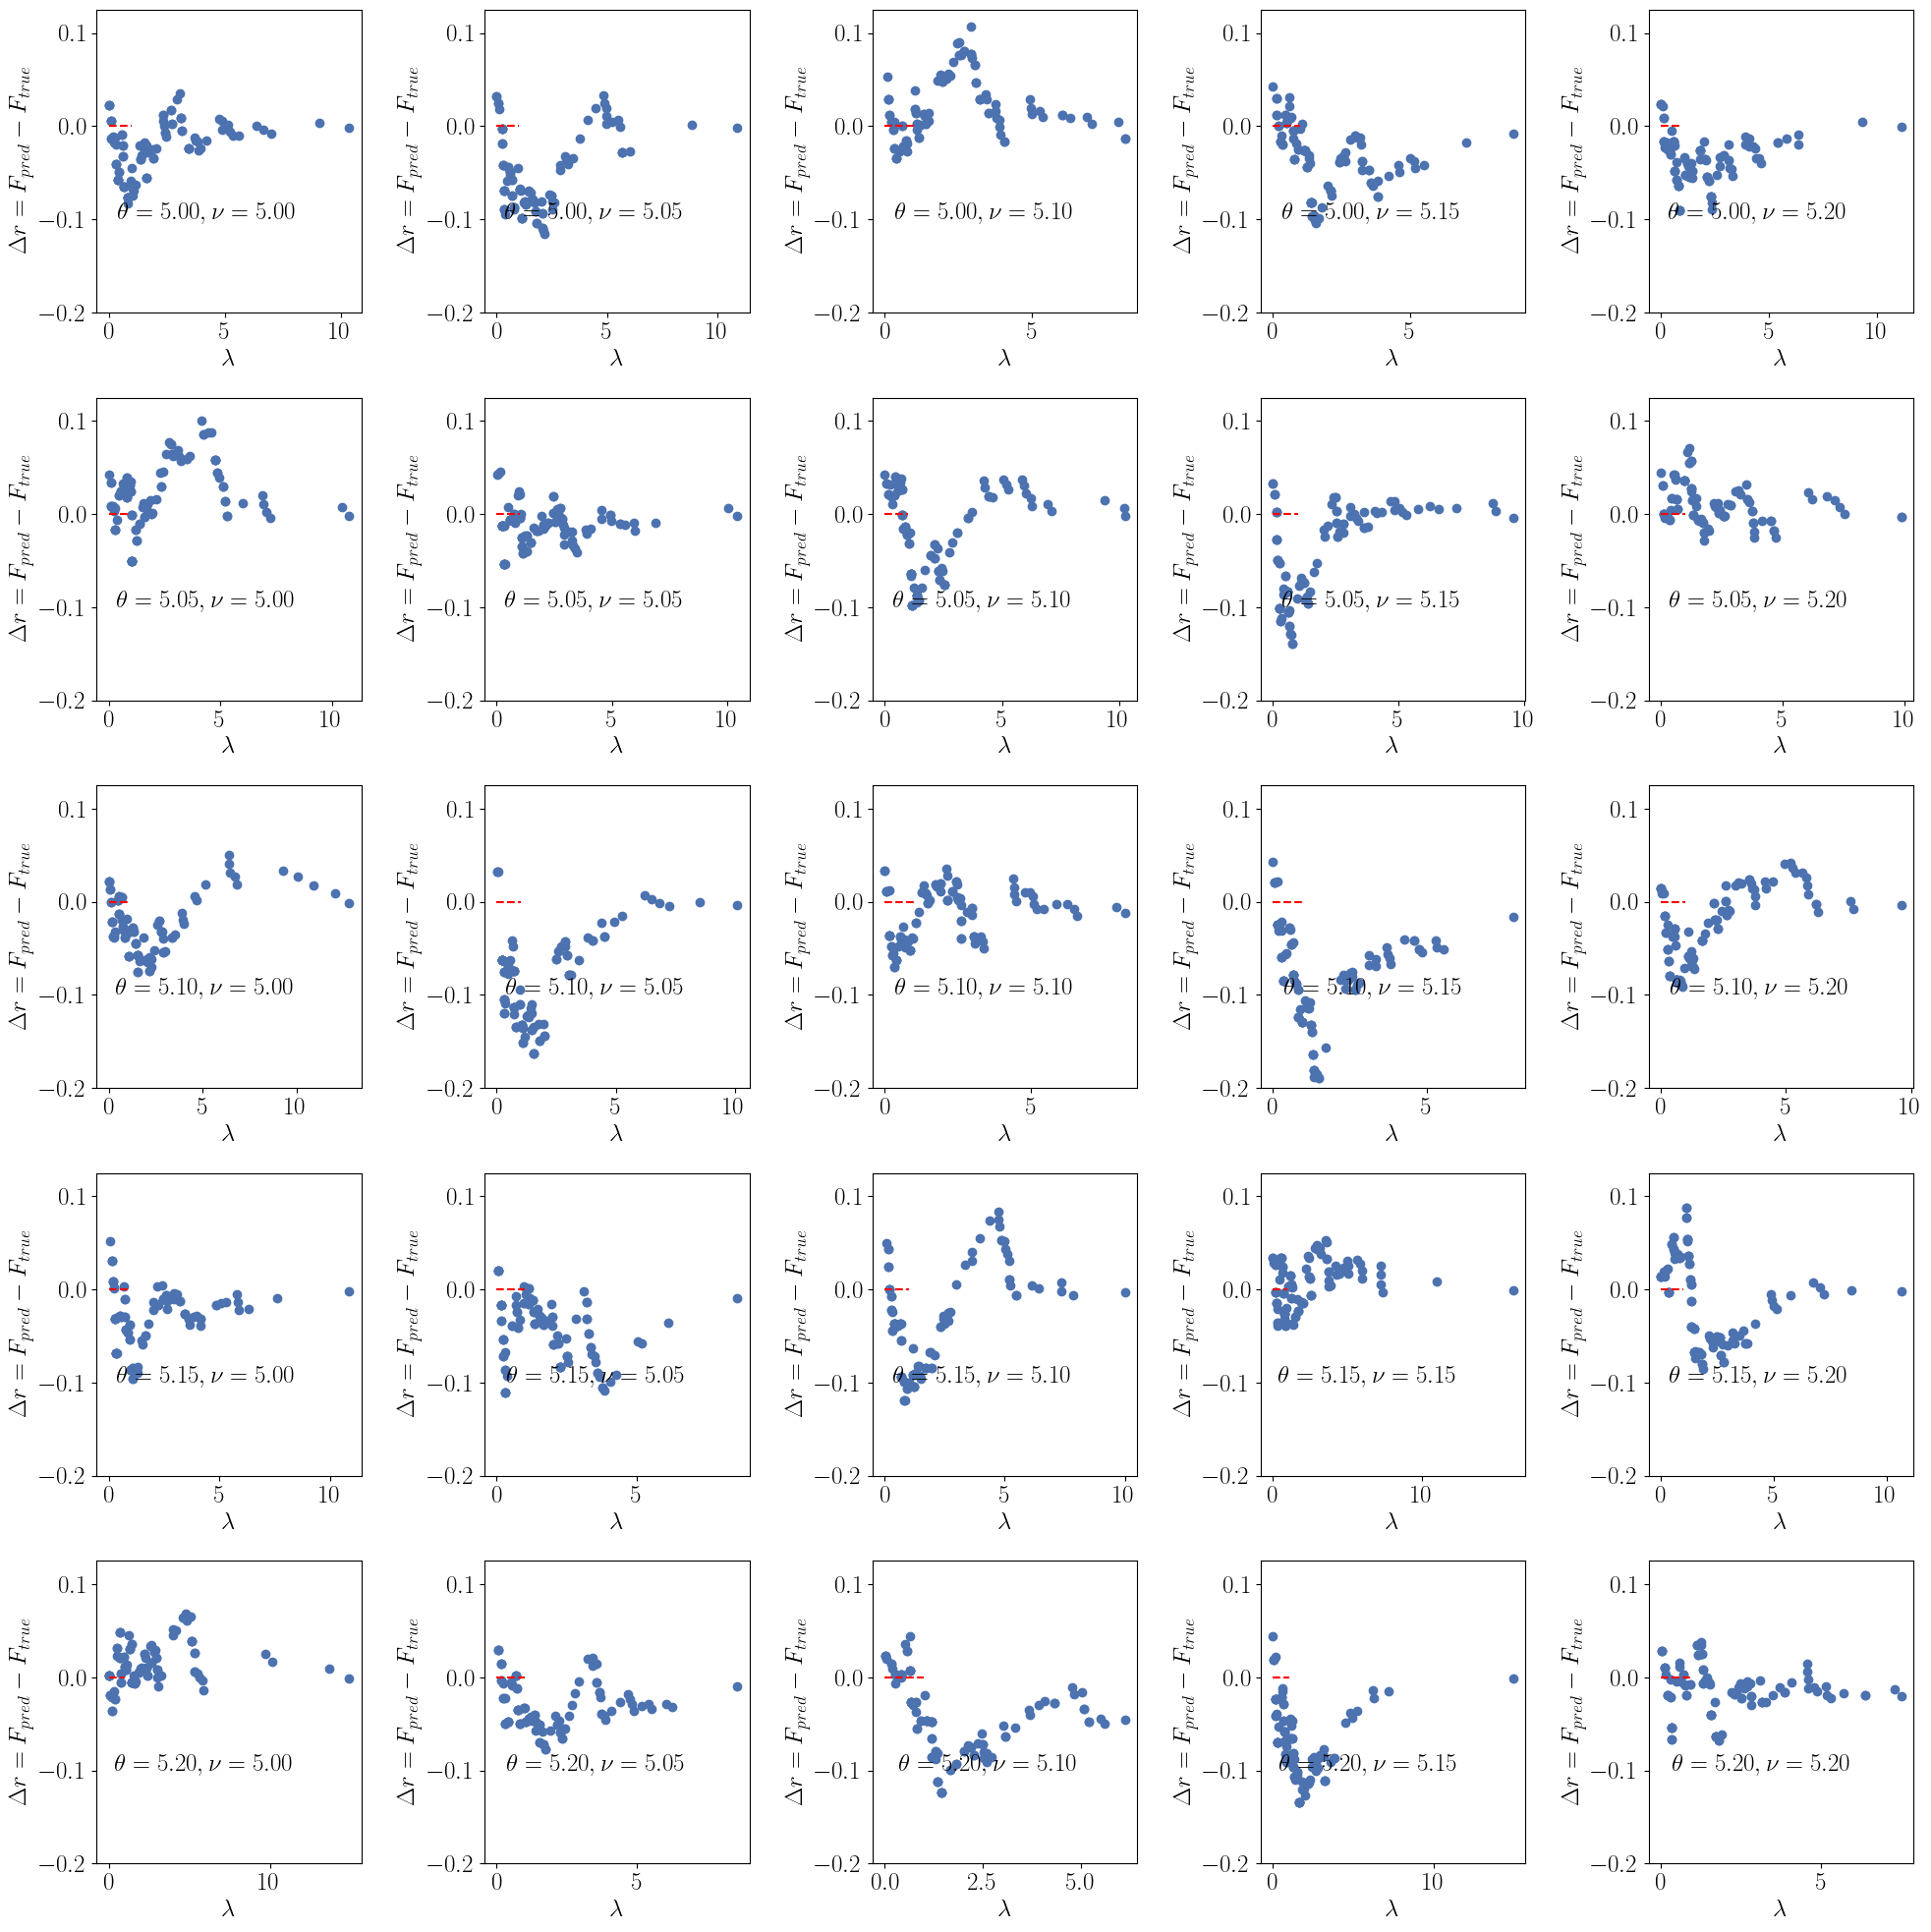

In [725]:
plot_q_deltar_points(nrows=5, ncols=5, scatter=True)